<a id='intro'></a>
## Introduction

### Dataset Description 

> This data set contains information
about 10,000 movies collected from
The Movie Database (TMDb),
including user ratings and revenue


### Question(s) for Analysis
>**Question 1**: What are the most 5 poplular movie genres and what is their revenue?

>**Question 2**: What are the most 2 associated genres?

>**Question 3**: What is the best studio that got these genres on the best rate?

>**Question 4**: How much money does it take to make a movie with these genres and with the best studio *Theoraticly* ? what is the possible revenue range ? 

In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

<a id='wrangling'></a>
## Data Wrangling


### Defining neccesary functions

In [2]:
def check_na_df(df:pd.DataFrame):
    '''
        parameters:
        df : the desired datafarme we wish to inspect
        this functions checks for nun values in each column of the desired df
        and returns a dataframe with the result 
    '''
    column_names = df.columns
    na_dict = {}
    for column in column_names:
        na_dict[column]=df[column].isna().sum()
    return pd.DataFrame(na_dict,index=['number of nan values']).transpose()

In [3]:
def seperating_strings_into_dfs(df:pd.DataFrame,column_name:str):
    '''
        parameters:
        df: pandas DataFrame
        column_name: String
        return: DataFrame
        In this function we are trying to split the strings with ('|') like('Action|Adventure|Thriller|Drama') 
        to a list ['Action','Adventure','Thriller','Drama'] and then map into this list to create a dictionary which we
        want to know how many times did this value repeated itself and added a value for the revenue and budget for each value
        to return in a dataframe to analyize it
    '''
    new_df=df.copy()
    new_df['budget'].fillna(new_df['budget'].mean(),inplace=True)
    new_df['revenue'].fillna(new_df['revenue'].mean(),inplace=True)
    new_df = new_df[[column_name,'budget','revenue']].dropna()
    seperated = {}
    for row in new_df.values:
        for value in row[0].split('|'):
            if(seperated.get(value)):
                seperated[value][0] +=1
                seperated[value][1] +=row[1]
                seperated[value][2] +=row[2]
            else:
                seperated[value]=[]
                seperated[value].append(1)
                seperated[value].append(row[1])
                seperated[value].append(row[2])
    return pd.DataFrame(seperated,index=['frequency','budget','revenue']).transpose().sort_values('frequency',ascending=False)

In [4]:
def getting_associated_genres(df:pd.DataFrame):
    '''
        parameters:
        df: DataFrame
        return DataFrame
        this functions goes into the genres column of the dataframe to find out top 2 common associated genres 
    '''
    associated_genres = {}
    for row in df:
        row_list = str(row).split('|')
        for first_value in range(len(row_list)):
            for second_value in range(first_value+1,len(row_list)):
                if(row_list[first_value]+'\n'+row_list[second_value] not in associated_genres):
                    if(row_list[second_value]+'\n'+row_list[first_value] not in associated_genres):
                        associated_genres[row_list[first_value]+'\n'+row_list[second_value]]=1
                    else:       
                        associated_genres[row_list[second_value]+'\n'+row_list[first_value]]+=1
                else:
                    associated_genres[row_list[first_value]+'\n'+row_list[second_value]]+=1
    return pd.DataFrame(associated_genres,index=['Frequency']).transpose().sort_values('Frequency',ascending=False)

##### dataframe challenges:
##### It is noticed that alot of the string values: (genre,cast,producting companies) have list of data inside of it seperated with ( **|** ) so we gonna split them and create a dataframe for each
>##### with the questions we want to ask it would be better if we used only the columns we are interested in

In [2]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
# removed unimportant columns
df = pd.read_csv('tmdb-movies.csv')
# df= df[['id','budget','revenue','director','genres','production_companies']]
df.head(2)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08


In [6]:
# data set data types
print(df.dtypes)

id                       int64
budget                   int64
revenue                  int64
director                object
genres                  object
production_companies    object
dtype: object


Here in this point I figured the relation to between The nan values to know what I am dealing with which encountered a second question will it make a huge difference if I dropped these nan rows ? which leads to the next point

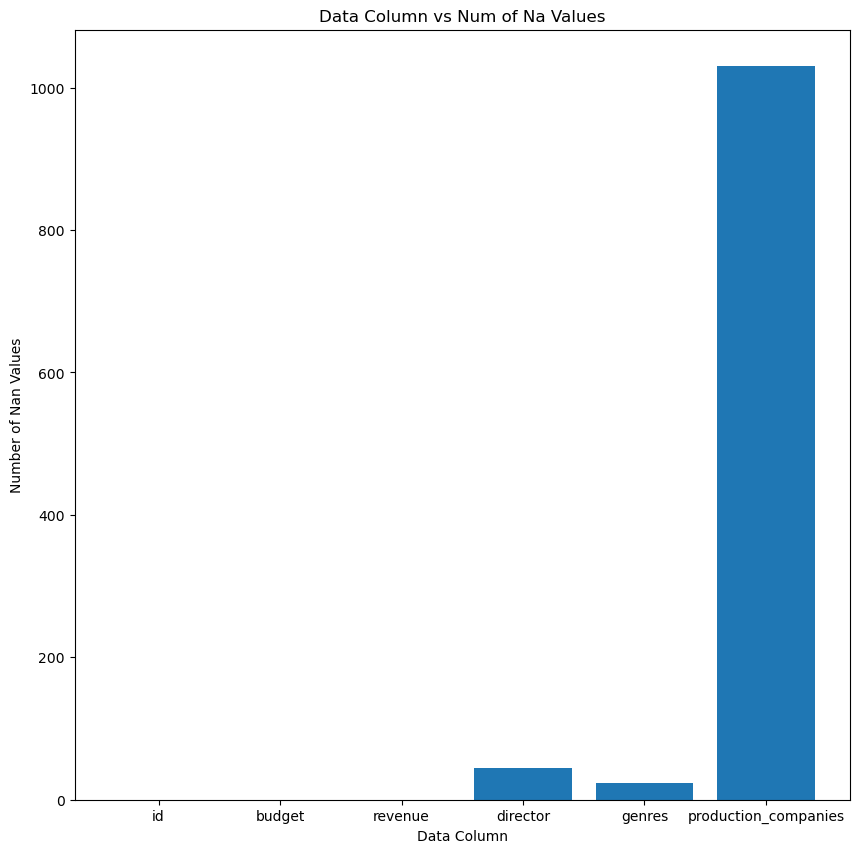

In [7]:
na_df=check_na_df(df=df)
plt.figure(figsize=(10,10))
plt.title('Data Column vs Num of Na Values')
plt.xlabel('Data Column')
plt.ylabel('Number of Nan Values')
location = np.arange(1,na_df.shape[0]+1)
heights = na_df['number of nan values'].values
labels = na_df.index.values
plt.bar(location,heights,tick_label = labels);

Knowing exactly the relation between the number of the remaining values if we dropped the na and the na values itself lead to the decision of dropping them as plotted it's only around 8% ofcourse it still affects the data accuracy but still looks great

In [8]:
df_after_na_dropping = df.shape[0]+df['production_companies'].isna().sum()

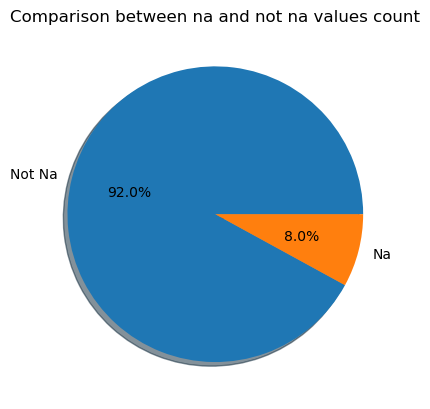

In [9]:
plt.title('Comparison between na and not na values count')
plt.pie([df_after_na_dropping,df['production_companies'].isna().sum()],labels=['Not Na','Na'],autopct='%1.1f%%',shadow=True);


### Data Cleaning
> with only 8% of the data missing from the production company column which is important in our analysis, Decided to drop all the rows to stay with 92% of the data 

> Got all the DataFrames ready to analysis with spliting text and getting the associated genres

In [10]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.
## here I droped the na values 
df.dropna(inplace=True)
genres = seperating_strings_into_dfs(df=df,column_name='genres')
production_companies = seperating_strings_into_dfs(df=df,column_name='production_companies')
top_2_associated_genres=getting_associated_genres(df['genres'])

There was almost no duplicates only 1 duplicated row in this step so deleting it was no problem

In [11]:
# checking for duplicates
df.duplicated().sum()
# deleting the duplicated value
df.drop_duplicates(inplace=True)
# checked again to make sure
df.duplicated().sum()

0

<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1 (Top 5 Common genres)
##### In this question asking about the top 5 highest frequency genres makes us know that the audience interests in the period which by knowing we are getting closer to know the best about the movie "History" in this time
here I splited the genres to get every genre and its frequency, revenue, budget to analyize 
first I used the frequency to know the most common one

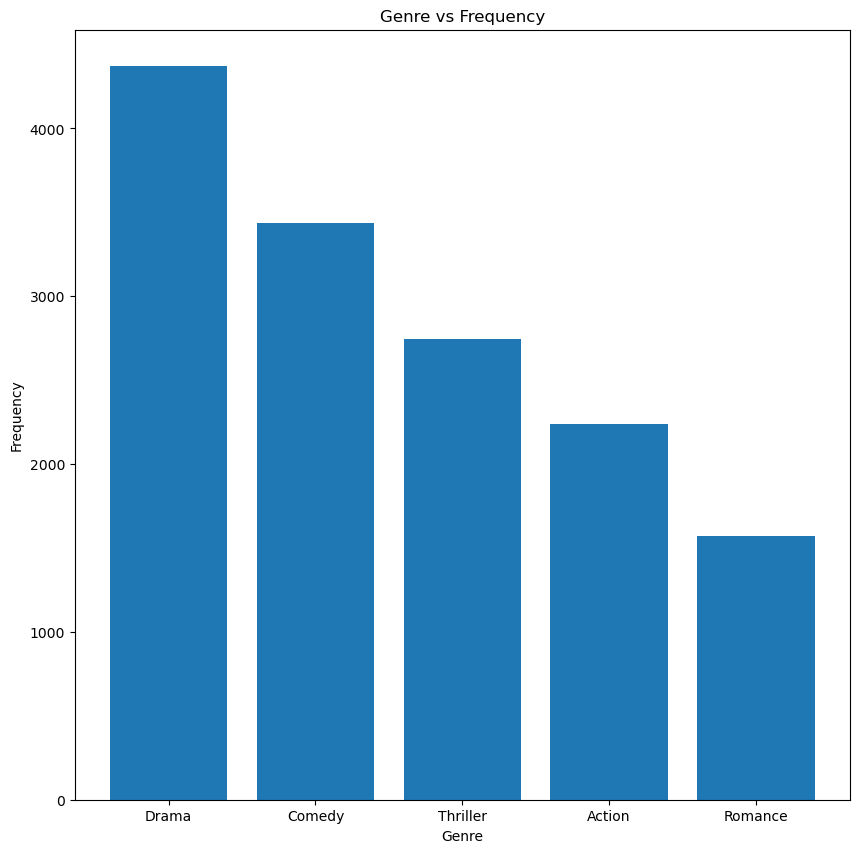

In [12]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.
#! A plot to describe the relation between Genre and frequency
plt.figure(figsize=(10,10))
plt.title('Genre vs Frequency')
plt.xlabel('Genre')
plt.ylabel('Frequency')
top_5_genres = genres.sort_values('frequency',ascending=False).head(5)
plt.bar(top_5_genres.index,top_5_genres['frequency']);

After that I got the revenue of each compared

In [13]:
# divided revenue by million to be easier to use
top_5_genres['revenue']=top_5_genres['revenue']/1000000

Drama       138896.772395
Comedy      142141.376544
Thriller    121189.561087
Action      173418.313979
Romance      61021.572866
Name: revenue, dtype: float64


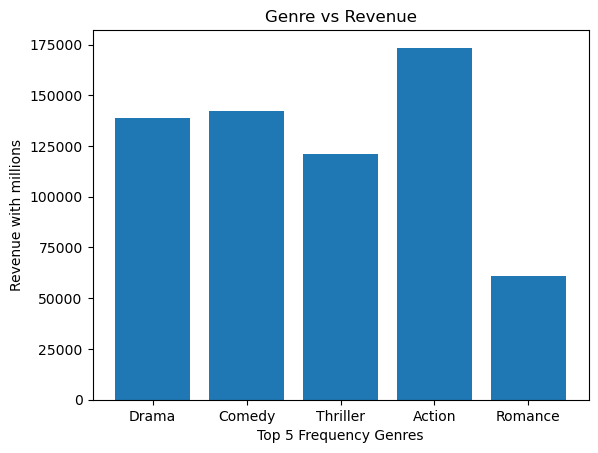

In [14]:
# A plot to describe the relation between top 5 Frequency genres and revenue
plt.title('Genre vs Revenue')
plt.xlabel('Top 5 Frequency Genres')
plt.ylabel('Revenue with millions')
plt.bar(top_5_genres.index,height=top_5_genres['revenue']);
print(top_5_genres['revenue'])

### Research Question 2  (Top 2 associated genres)
Asking this question to know the most common couple of genres as every movie has more than 1 genre
#
here I got all the 2 genres that came togather in movies and compared thier frequencies to get the top couple genres

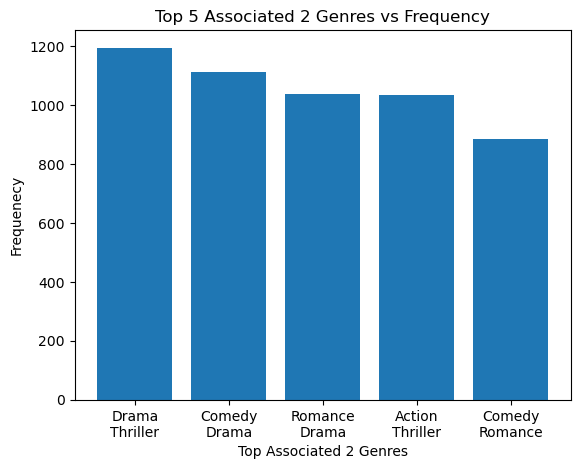

In [15]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.
# A plot to describe the relation between the top 5 associated 2 genres and their frequency
plt.title('Top 5 Associated 2 Genres vs Frequency')
plt.xlabel('Top Associated 2 Genres')
plt.ylabel('Frequenecy')
plt.bar(top_2_associated_genres.head().index,top_2_associated_genres.head()['Frequency']);

### Research Question 3  (which production company got these genres in the best rate)
##### As a result for the previous knowing the most 2 common genres means there was alot of movies made with them with more competition than other genres  
here I got only the rows with drama and thriller genres togather and got the companies that casted them and compared the revenue between them

In [16]:
research_df = df.copy()
research_df=df[(df['genres'].str.contains('Drama'))]
research_df=df[df['genres'].str.contains('Thriller')]
research_df=research_df.sort_values('revenue',ascending=False)

In [17]:
companies_df=seperating_strings_into_dfs(research_df,'production_companies')
companies_df.sort_values('revenue',ascending=False,inplace=True)

In [18]:
companies_df['revenue']=companies_df['revenue']/1000000

##### As you can see from this plot, the top company getting revenue from the top couple genres was Warner Bros. 

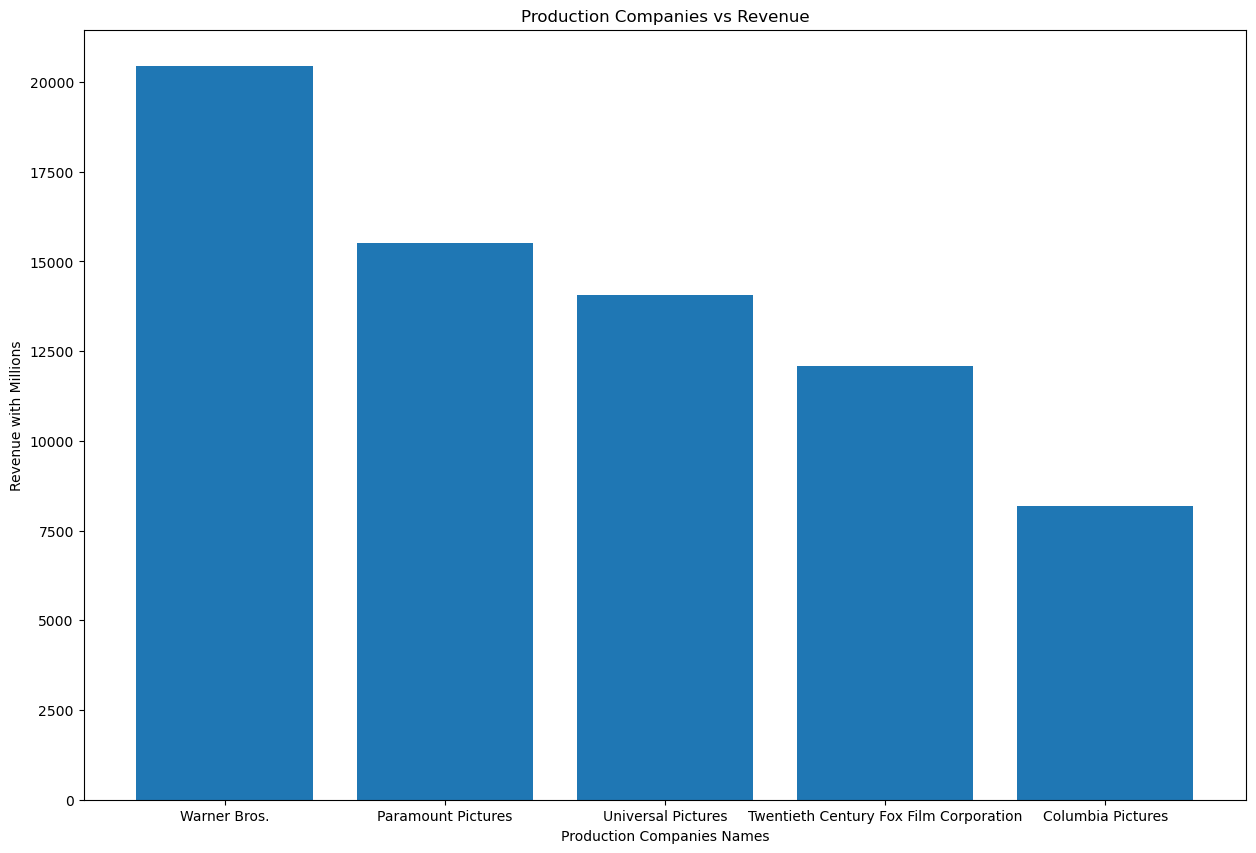

In [19]:

plt.figure(figsize=(15,10));
plt.title('Production Companies vs Revenue')
plt.xlabel('Production Companies Names')
plt.ylabel('Revenue with Millions')
plt.bar(companies_df.head().index,companies_df.head()['revenue']);

### Research Question 4  (What is the difference between the top 1 company budget and revenue ?)
##### first of all modified the dataframe to get only the rows where the company 'Warner Bros.' can be found
##### here I found that some of the revenues and budgets are 0s so I splitted them to proceed
##### divided them by 1million so the analysis can be easier

In [20]:
research_df = research_df[research_df['production_companies'].str.contains('Warner Bros.')]
research_df = research_df[research_df['budget']>0]
research_df = research_df[research_df['revenue']>0]
research_df

,id,budget,revenue,director,genres,production_companies
4363,49026,250000000,1081041287,Christopher Nolan,Action|Crime|Drama|Thriller,Legendary Pictures|Warner Bros.|DC Entertainme...
2875,155,185000000,1001921825,Christopher Nolan,Drama|Action|Crime|Thriller,DC Comics|Legendary Pictures|Warner Bros.|Syncopy
1919,27205,160000000,825500000,Christopher Nolan,Action|Thriller|Science Fiction|Mystery|Adventure,Legendary Pictures|Warner Bros.|Syncopy
4954,604,150000000,738599701,Lilly Wachowski|Lana Wachowski,Adventure|Action|Thriller|Science Fiction,Village Roadshow Pictures|NPV Entertainment|He...
5423,49047,105000000,716392705,Alfonso CuarÃ³n,Science Fiction|Thriller|Drama,Warner Bros.|Heyday Films|Esperanto Filmoj
...,...,...,...,...,...,...
8883,36047,15000000,5217498,Mary Lambert,Thriller,Warner Bros. Pictures
8788,18041,14000000,5108820,Davis Guggenheim,Drama|Mystery|Thriller,Warner Bros. Pictures
9932,636,777000,2437000,George Lucas,Drama|Mystery|Science Fiction|Thriller,American Zoetrope|Warner Bros.
9358,13154,8000000,2275557,Mark L. Lester,Action|Thriller,Warner Bros.


In [21]:
research_df['budget']=research_df['budget']/1000000
research_df['revenue']=research_df['revenue']/1000000

having all the credintals ready I started the analysis process

In [22]:
print(research_df[['budget','revenue']].describe())

           budget      revenue
count  136.000000   136.000000
mean    54.963434   146.642227
std     47.748327   193.031256
min      0.777000     0.428868
25%     19.750000    30.074329
50%     45.000000    78.561165
75%     70.000000   163.615694
max    250.000000  1081.041287


0.37481314286003203


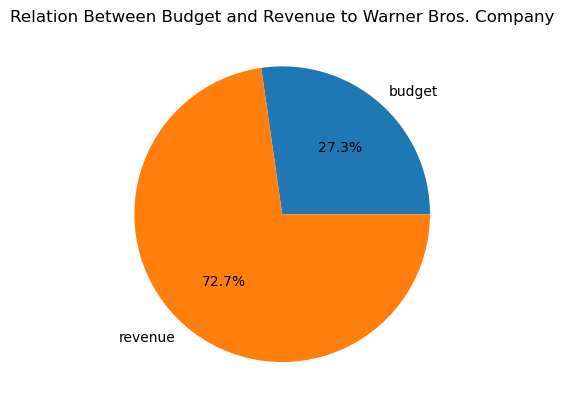

In [30]:
plt.title('Relation Between Budget and Revenue to Warner Bros. Company')
plt.pie([research_df['budget'].sum(),research_df['revenue'].sum()],autopct='%1.1f%%',labels=['budget','revenue'],);

<a id='conclusions'></a>
## Conclusions

> With the missing data about the production companies we could only provide 92% of the data tested having the last 8% would be great as well for the next analysis

> After analyzing we found out that the most common genres is (Drama , Comedy , Thriller , Action , Romance ) in order Even though action isn't the first in common but it is the first in revenue and drama is the third after comedy by knowing that it means the frequency isn't for sure meaning more revenue

> Knowing that alot of genres do repeat in couples alot that made knowing the most frequency better than treating genres 1 by 1, Then I wanted to know about the most 2 associated genres and they were Drama and Thriller with more than 1100 movie knowing that I could proceed to the next test

> Which companies can do the best out of these 2 genres and it was one of the biggest Warner Bros. knowing that we had all the credintals to the last test

> Warner bros company made around 20 billion dolar over the years from only around 7.5 billion which is exactly 45.4% more than the budget 
## *Limitation*
It was indeed a great detailed dataset with great columns but having only 10000 line made this process so weak from the huge population of movies having only a sample of 10000 made this analysis process so limited maybe knowing the money from selling the movies from movie shop or the cinema made how much of the revenue and compare them with each other can surpass more limitation for us.